In [6]:
# 05 - 02.ipynb

- TF-IDF : 텍스트 벡터화
- PCA : 차원 축소
- LSA : 잠재 의미 분석
- t-SNE : 2D 시각화
- 로지스틱 회귀
- 토큰화 & 전처리

In [7]:
# LSA
# TF-IDF 행렬에 대해서 SVD 를 적용 하여 분리
# 단어와 문서간의 숨겨진 의미 관계를 찾음
# PCA 차이 :
    # PCA : 데이터 자체 분산
    # LSA : 문서 - 단어 형태의 의미 구조 파악
# "은행"
    # "돈" " 계좌" 주변에 등장
    # "나무" " 냄새" "먹는다" 주변에 등장

In [8]:
# t-SNE : 고차원 데이터를 2D / 3D로 변환 - 시각화 전용(분석에는 부적합), 계산이 오래걸림
# PCA vs t-SNE
# PCA : 속도가 빠름, 전역 구조 보존
# t-SNE : 느림, 국소(지역)  군집 명확

In [9]:
# 데이터셋
from sklearn.datasets import load_files
from sklearn.datasets import fetch_20newsgroups
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']

# data load
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove = ('headers','footers','quetes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                      remove = ('headers','footers','quetes'),
                                      categories=categories)
categories =  ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
import re

def clean_text(text):
    # 헤더 제거
    text = re.sub(r'^From:.*\n', '', text, flags=re.MULTILINE)
    text = re.sub(r'^Subject:.*\n', '', text, flags=re.MULTILINE)

    # 풋터 제거
    text = re.sub(r'\n--\n.*$', '', text, flags=re.DOTALL)

    # 인용문 제거
    text = re.sub(r'(^|\n)[>|:].*', '', text)

    return text
# 카테고리 제거
def filter_categories(dataset, categories):
    target_names = dataset.target_names
    selected_idx = [ target_names.index(c) for c in categories  ]
    #필터링
    data_filtered, target_filtered = [], []
    for text,label in zip(dataset.data, dataset.target):
        if label in selected_idx:
            new_label = selected_idx.index(label)  # 라벨 재 정렬
            data_filtered.append(text) ; target_filtered.append( new_label  )
    return data_filtered,target_filtered,categories
train_data, train_target, target_names = filter_categories(newsgroups_train,categories)
test_data, test_target, _ = filter_categories(newsgroups_test,categories)

x_train = [ clean_text(t) for t in train_data]
x_test = [ clean_text(t) for t in test_data]
y_train = train_target
y_test = test_target

In [12]:
# 텍스트 전처리 ( 소문자 + 토큰화 + 불용어제거(stop words) + 어간추출(stemming)) --> 영어
# 위순서 대로 파이프라인 작성
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem .porter import PorterStemmer # 같은 의미의 다른형태 단어를 통일
from sklearn.feature_extraction.text import TfidfVectorizer
regtok = RegexpTokenizer(r"[\w']{3,}")
english_stops = set(stopwords.words('english'))
# 커스텀 토크나이저
def tokenizer(text):
    tokens = regtok.tokenize(text)
    words = [word for word in tokens if word not in english_stops]
    features = list(map(lambda x : PorterStemmer().stem(x), words))
    return features
# TF-IDF 벡터화
tfidf = TfidfVectorizer(tokenizer=tokenizer,max_features=2000,max_df=0.5,min_df=2)
x_train_tfidf = tfidf.fit_transform(x_train)
x_test_tfidf = tfidf.transform(x_test)
# 분류모델
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter=200,random_state=42)
lr_clf.fit(x_train_tfidf,y_train)

print('기본분류 ---------------')
print(f'학습정확도 : {lr_clf.score(x_train_tfidf,y_train)}')
print(f'테스트정확도 :{lr_clf.score(x_test_tfidf,y_test)}')
print('주성분 분석')
# 데이터의 분산이 가장 큰 방향
# 선형반환만 가능
# 모든데이터의 특성을 평등하게 고려
# 용도 : 시각화 , 속도개선
# 2000차원 -> 100차원 축소
from sklearn.decomposition import PCA
pca = PCA(n_components=100, random_state=42)
x_train_pca = pca.fit_transform(x_train_tfidf.toarray())
x_test_pca = pca.transform(x_test_tfidf.toarray())

import numpy as np
cumsum_var = np.cumsum(pca.explained_variance_ratio_)
print(f'원본 차원 : {x_train_tfidf.shape[1]}')
print(f'축소후 차원 : {x_train_pca.shape[1]}')
print(f'설명된 분산 : {pca.explained_variance_.sum()}')
print(f'누적 분산 : {cumsum_var[:10]}')


# pca 후 분류
lr_clf_pca = LogisticRegression(max_iter=200,random_state=42)
lr_clf_pca.fit(x_train_pca,y_train)

print('주성분 분석 분류 ---------------')
print(f'학습정확도 : {lr_clf_pca.score(x_train_pca,y_train)}')
print(f'테스트정확도 :{lr_clf_pca.score(x_test_pca,y_test)}')

c:\Users\Playdata2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


기본분류 ---------------
학습정확도 : 0.9528023598820059
테스트정확도 :0.7649667405764967
주성분 분석
원본 차원 : 2000
축소후 차원 : 100
설명된 분산 : 0.3065023498651796
누적 분산 : [0.01352857 0.02478358 0.03493127 0.04326532 0.050367   0.05722346
 0.062777   0.06799247 0.07306382 0.07775797]
주성분 분석 분류 ---------------
학습정확도 : 0.8485742379547689
테스트정확도 :0.7612712490761271


In [13]:
# lsa 잠재적 의미 분석 (그냥 단어들 쪼개서하는거..잖아..!!)
# tf-idf svd
# PCA보다 의미론적 관계 잘 포착
# 테스트 데이터에 효과적

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100,random_state=42)
x_train_lsa = svd.fit_transform(x_train_tfidf)
x_test_lsa = svd.fit_transform(x_test_tfidf)

print(f'원본 차원 : {x_train_tfidf.shape[1]}')
print(f'축소후 차원 : {x_train_lsa.shape[1]}')
print(f'설명된 분산 : {svd.explained_variance_.sum()}')

# lsa 후 분류
lr_clf_lsa = LogisticRegression(max_iter=200,random_state=42)
lr_clf_lsa.fit(x_train_lsa,y_train)

print('주성분 분석 분류 ---------------')
print(f'학습정확도 : {lr_clf_lsa.score(x_train_lsa,y_train)}')
print(f'테스트정확도 :{lr_clf_lsa.score(x_test_lsa,y_test)}')

원본 차원 : 2000
축소후 차원 : 100
설명된 분산 : 0.3375343564944817
주성분 분석 분류 ---------------
학습정확도 : 0.8515240904621436
테스트정확도 :0.17664449371766444


In [17]:
# LSA 기반 유사도 분석
# 코사인 유사도 0
# LSA 의미 기반 유사도
# 첫번째 문서의 유사 문서 찾기
from sklearn.metrics.pairwise import cosine_similarity
sim_result = cosine_similarity([x_train_lsa[0]], x_train_lsa)
sim_index = (-sim_result[0]).argsort()[:20]
print(f'원문 카테고리 : {newsgroups_train.target_names[y_train[0]]}')
print(f'상위 유사도 : {sorted(sim_result[0],reverse=True)[:5]}')
similar_categorys = [newsgroups_train.target_names[y_train[i]] for i in sim_index]
print(f'유사 문서들의 카테고리 : {similar_categorys[:10]}')

원문 카테고리 : sci.space
상위 유사도 : [np.float64(1.0000000000000002), np.float64(0.8211703949849414), np.float64(0.8052376014904978), np.float64(0.7964873871921037), np.float64(0.7615710115405203)]
유사 문서들의 카테고리 : ['sci.space', 'sci.space', 'sci.space', 'sci.space', 'sci.space', 'sci.space', 'sci.space', 'sci.space', 'sci.space', 'sci.space']


In [ ]:
# t-sne 2D 시각화
# 고차원 데이터를 2D/3D로 변환
# 비슷한 데이터는 가깝게 다른데이터는 멀리 배치
# 계산이 오래걸리지만 시각화 효과가 뛰어나다.
# 주의 : 분석용이 아니라 시각화 전용

In [19]:
# t-sne 가져오기
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
# perplexity 이웃 개수 조절

tsne_lsa = tsne.fit_transform(x_train_lsa)
print(f'입력 차원 : {x_train_lsa.shape[1]}')
print(f'출력 차원 : {tsne_lsa.shape}')

입력 차원 : 100
출력 차원 : (2034, 2)


In [21]:
# %pip install matplotlib

  Using cached matplotlib-3.10.7-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp313-cp313-win_amd64.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.7-cp313-cp313-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl (226 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.60.1-cp313-cp313-win_amd64.whl (2.3 MB)
Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl (73 kB)
Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)

   ---------------------------------------- 0/6 [pyparsing]
   ---------------------------------------- 0/6 [pyparsing]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- --

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


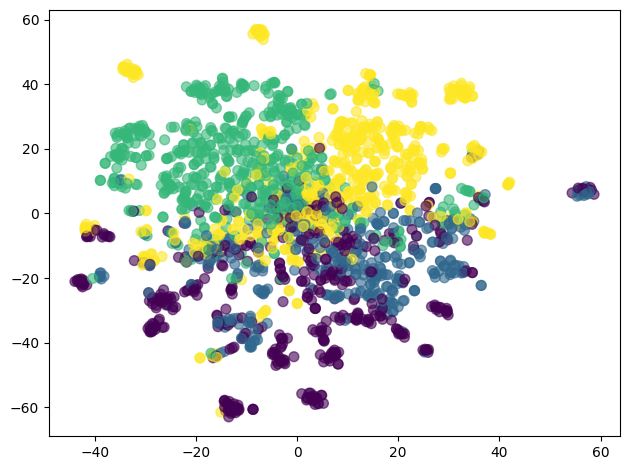

In [22]:
import matplotlib.pyplot as plt
colors = y_train[:len(tsne_lsa)]
plt.scatter(tsne_lsa[:,0],tsne_lsa[:,1],c = colors, cmap = 'viridis', alpha=0.6, s=50)
plt.tight_layout()
plt.show()

In [ ]:
# TF-IDF 원본데이터
    # 장점 : 해석이 쉽고 정확도가 높은
    # 단점 : 메모리 많이 사용 (차원이 높음 -> 차원의 저주)
    # 용도 : 정확도가 우선일 때
# PCA 선형 차원 축소
    # 장점 : 계산이 빠르고 간단, 분산 최대 보존
    # 단점 : 선형 변환만 가능
    # 용도 : 속도와 정확도 균형
# LSA 의미 기반 차원 축소
    # 장점 : 의미관계 잘 포착, 유사도 계산에 효과적
    # 단점 : 계산비용 중간
    # 용도 : 문서 유사도, 추천 시스템
# t-SNE 비선형 시각화
    # 장점 : 군집구조 명화히 보임
    # 단점 : 계산이 오래걸림, 분석용이 아닌 시각화
    # 용도 : 데이터 탐색 및 이해

```
텍스트 분류

정확도 최우선                속도중요(메모리)                       시각화 필요
  TF-IDF                          PCA                                t-SNDE
  ```

In [ ]:
# 한국 데이터
import pandas as pd
url = "https://drive.google.com/uc?id=1KOKgZ4qCg49bgj1QNTwk1Vd29soeB27o"
df = pd.read_csv(url)

if not os.path.exists(data_dir):
    sel._create

In [ ]:
# 한국어 데이터로 진행
# 데이터 ( 문장 )
    # 문장 -> 벡터
        # 문장 -> 토큰화
        # 다양한 토크나이저
            # 한글 Okt
                # Okt().pos(문장)
                # 불용어 제거 - 불용어 리스트를 만들어서 stopword 하듯이 제거
    # 토큰 -> 벡터화
        # BoW(CounterVectorizer)
        # TF-IDF
# 분류모델 선택
# 학습
# 평가